# T cells mapped to T2T version 2.0
# Day 6 post EP for CRISPoff and unedited
# Pipeline to Extract and Analyze mC profiles from BAM files and look at Forward & Reverse strands

Date: Aug. 12, 2025
Modify the window of the input size

Save subsets of reads

In [1]:

import sys
from pathlib import Path
from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
# import time
# import shap


# Add the folder containing 'my_functions.py' to sys.path
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))

# Import the module or specific functions
# from /home/michalula/code/epiCausality/epiCode/utils/funcs_extract_mC_profiles_from_BAMs.py
# from funcs_extract_mC_profiles_from_BAMs import system_info, extract_from_bam
from funcs_extract_mC_profiles_from_BAMs import (
    system_info,
    get_reference_sequence,
    create_output_directory,
    extract_from_bam,
    process_extracted_reads,
    visualize_data,
    create_padded_reads,
    plot_padded_reads,
    save_padded_reads,
    remove_low_methylated_reads,
    process_extracted_reads_no_fully_unmethylated,
    create_padded_reads_no_fully_unmethylated,
    subset_BAM_by_read_IDs,
    bam_to_sam,
    plot_bam_quality_metrics
    # main,
)
from funcs_analize_forward_reverse_extracted_mC_reads import analize_forward_reverse_CGs_pipeline

modkit found with expected version 0.2.4


In [7]:
system_info()
date_today = datetime.today().strftime('%Y-%m-%d')
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta')
reg_genome_version = "t2t_v2_0"
region_chr = 'chr1'

# 6500bps: EXACT cutting region  
# chr1:206,583,334-206,589,873
region_start = 206583334    + 20
region_end = 206589874      - 20 
# CD55 TSS start: chr1:206586828-206606065 (+)
# (before TSS: 3474, after TSS: 3026 bps)

region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
region_length = region_end - region_start
print("region_length", region_length)


motifs=['CG,0']
ref_seq_list = get_reference_sequence(ref_genome_path, region_chr, region_start, region_end)

print('region_chr', region_chr)
print('region_start', region_start)
print('region_end', region_end)
print(f'{region_chr}:{region_start}-{region_end}') 

System: Linux
Release: 6.8.0-60-generic
Version: #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
region_length 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTA

# Look at UNEDITED (NT = Not Treated) T cells at day 6 post EP (with no proteins)


In [8]:
unedit_bam_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

# day 6:  "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
unedit_bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [ ]:
threshold_mC = 0.995 #0.7 #  0.9 #0.99
experiment_name = "day28_unedited_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
bam_path = unedit_bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list, 
    keep_full_coverage_reads_only=keep_full_coverage_reads_only)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


In [9]:
threshold_percent = 50
filtered_reads_df, methylation_counts, remove_reads_df = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

NameError: name 'reads_df' is not defined

In [10]:
remove_reads_df

NameError: name 'remove_reads_df' is not defined

In [11]:
bam_path

NameError: name 'bam_path' is not defined

In [12]:
output_dir_path = "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
removed_reads_bam_name = "reads_with_mC_less_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
output_bam_path=Path(output_dir_path, removed_reads_bam_name)
output_bam_path

NameError: name 'experiment_name' is not defined

In [13]:
subset_BAM_by_read_IDs(bam_path, remove_reads_df, output_bam_path=output_bam_path, index_output=True)


NameError: name 'bam_path' is not defined

In [14]:

sam_path = bam_to_sam(output_bam_path, sam_path=None)
sam_path
removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
removed_reads_bam_path
plot_bam_quality_metrics(removed_reads_bam_path)

NameError: name 'output_bam_path' is not defined

# Load BAM files

In [15]:
removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
removed_reads_bam_path

'/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'

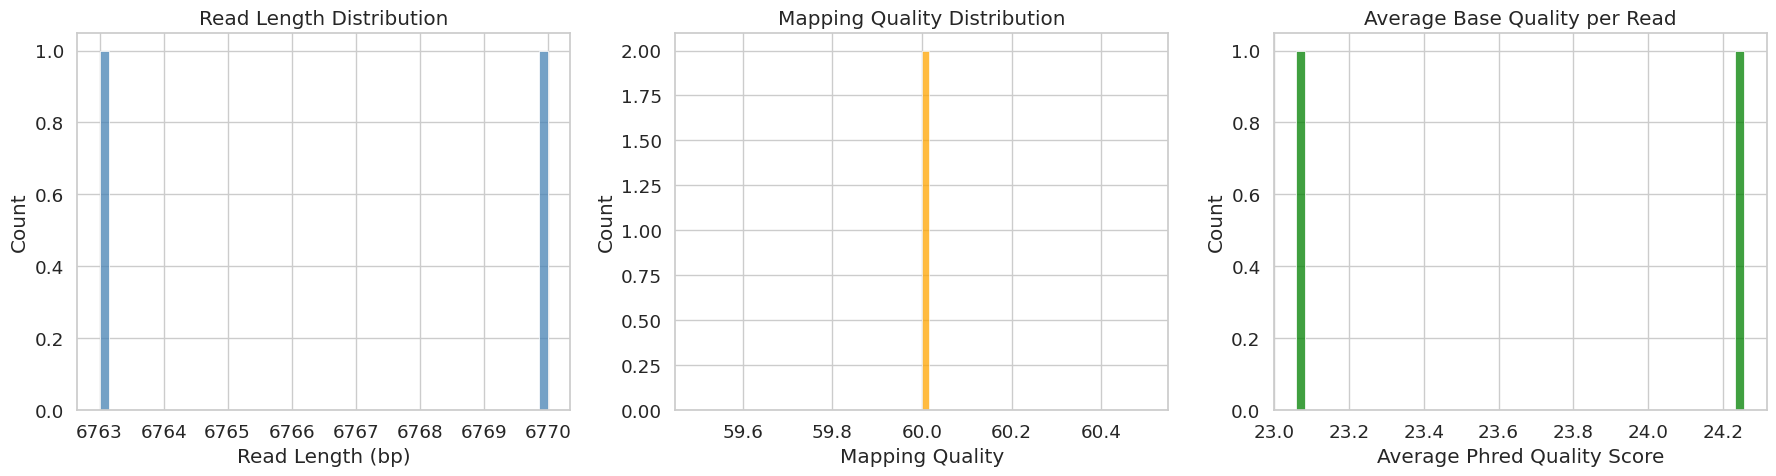

Total reads processed: 2


In [16]:
plot_bam_quality_metrics(removed_reads_bam_path)

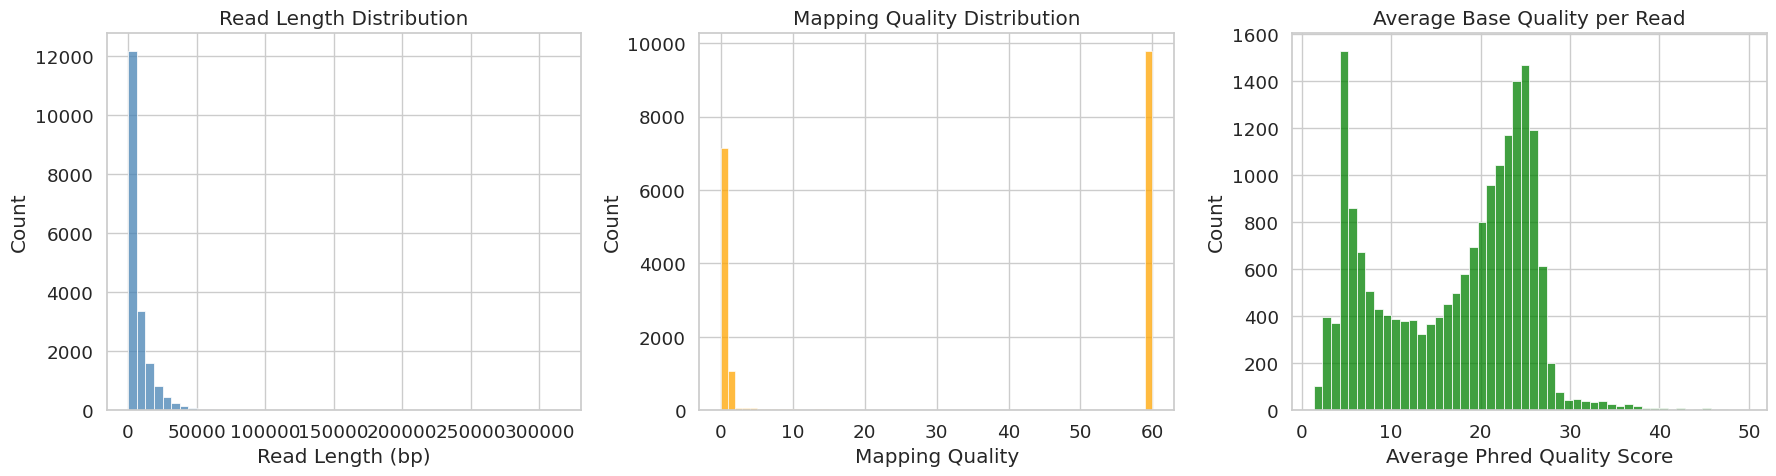

Total reads processed: 19039


In [17]:
plot_bam_quality_metrics(unedit_bam_path)

In [18]:
region_str

'chr1:206583354-206589854'

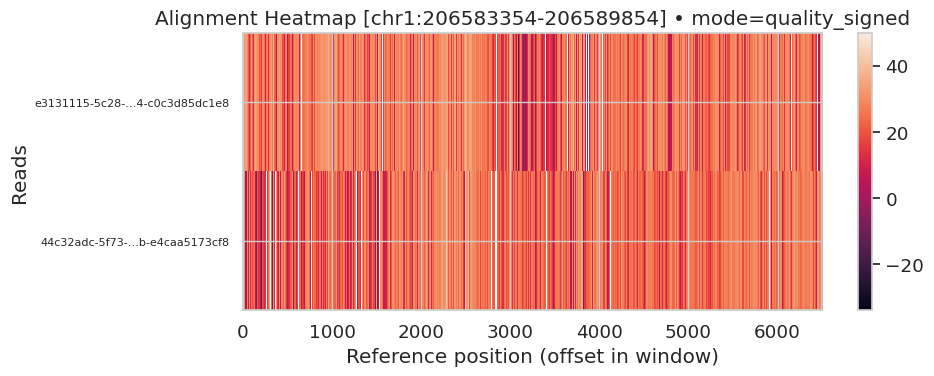

In [19]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)


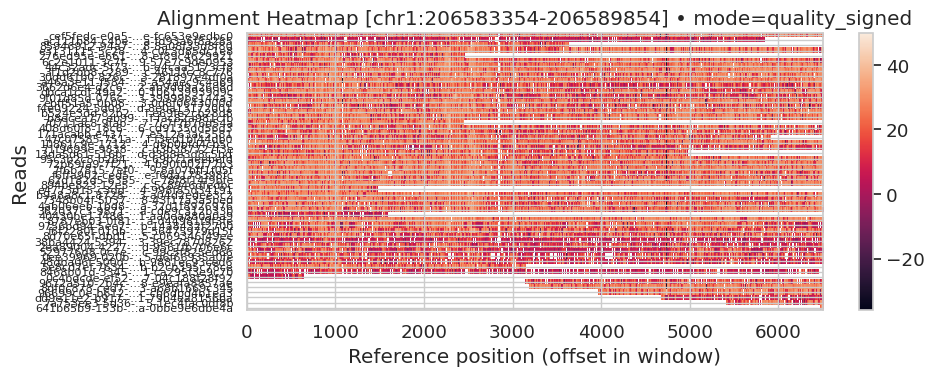

In [20]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = unedit_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)
